# Modelling

In [1]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
# group columns by meanings
shape_cols = ['Aspect.Ratio','Geodesic.Aspect.Ratio','Circularity','Circularity..Hu.','Elongation','Perimeter']
texture_cols = ['Transparency','Edge.Gradient','Roughness','Sigma.Intensity','Sum.Intensity','Intensity']
size_cols = ['Area..ABD.','Area..Filled.','Diameter..FD.','Diameter..ESD.','Diameter..ABD.','Width','Length','Geodesic.Length']
convexity_cols = ['Convex.Perimeter','Convexity','Compactness']
env_cols_non_numeric = ['wind','loc','site']
env_cols_numeric = ['lat0','lat1','lon0','lon1','burbotden', 'avgdepth', 'precip', 'xwaveht', 'mindepth', 'otherfishden', 'cloud_pc', 'maxdepth', 'watert', 'yperchden', 'xangle']
machine_cols = ['gdd2','volbest','trawltime','sam', 'rep', 'repnum', 'fr', 'effspeed']
datetime_cols = ['doy', 'day', 'year', 'month']
file_cols = ['tifffile','csvfile','Image.File','source_file','Time','Timestamp','key','Original.Reference.ID','Date']
image_profile_cols = ['Image.X', 'Image.Y', 'Capture.X', 'Capture.Y', 'Image.File', 'Calibration.Factor', 'Calibration.Image','Camera']

In [3]:
final_output = "merged_filtered_zooplankton_data.csv"  # Final merged file
df = pd.read_csv(final_output)
df['Class'] = df['Class'].map({'Calanoid_1':'Calanoid', 'Cyclopoid_1':'Cyclopoid'}) # Clean original class name

In [4]:
# Count missing values per column
missing_values = df.isnull().sum() / df.shape[0]
print(missing_values[missing_values > 0])  # Show only columns with missing values


Biovolume..Cylinder.       0.968085
Biovolume..P..Spheroid.    0.968085
Biovolume..Sphere.         0.968085
distshore                  0.127260
whitefishden               0.016349
unknwcoregonine            0.016349
ciscoden                   0.016349
exposure                   0.028159
smeltden                   1.000000
dtype: float64


Based on the meaning of these columns, those are not significant. Igonre these in the analysis. 


In [5]:
missing_cols = missing_values[missing_values > 0].index
cols_interested = list(set(df.columns).difference(set(missing_cols)))
df = df[cols_interested]

In [6]:
df.shape

(394263, 91)

# Full model

## Random forest


Classification Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     40529
           1       0.93      0.92      0.93     38324

    accuracy                           0.93     78853
   macro avg       0.93      0.93      0.93     78853
weighted avg       0.93      0.93      0.93     78853


Confusion Matrix:
[[37994  2535]
 [ 2908 35416]]

F1 Score:
0.9286397902327106

Recall :
0.9241206554639391

Precision :
0.9332033411504308

ROC curve:


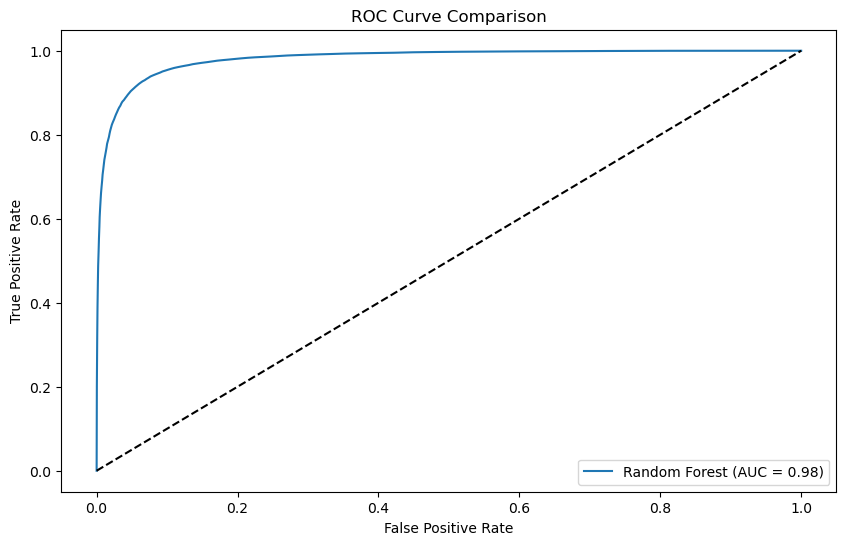

In [7]:
non_numeric_cols = env_cols_non_numeric + env_cols_numeric +machine_cols+datetime_cols+file_cols+['Class']
df_features = df.drop(columns=non_numeric_cols, errors="ignore")

y = df['Class'].map({'Calanoid':0, 'Cyclopoid':1}) 

X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.2, random_state=42) # 80/20 train test split

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)  
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nF1 Score:")
print(f1_score(y_test, y_pred))

print("\nRecall :")
print(recall_score(y_test, y_pred))
print("\nPrecision :")
print(precision_score(y_test, y_pred))

print("\nROC curve:")
rf_probs = clf.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = auc(rf_fpr, rf_tpr)

plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

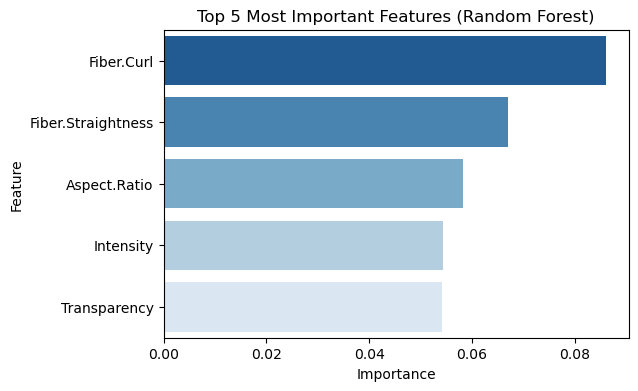

In [8]:
# Get feature importance
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": clf.feature_importances_
})

# Sort and plot top 5 features
feature_importance = feature_importance.sort_values(by="Importance", ascending=False).head(5)

plt.figure(figsize=(6, 4))
sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="Blues_r")
plt.title("Top 5 Most Important Features (Random Forest)")
plt.show()

Random forest using all the features achieved ~93% accuracy / F1 / Recall. The model performs very well but is too complex.

## XGBoost

/Users/christinaflz/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:15:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

    Calanoid       0.93      0.93      0.93     40529
   Cyclopoid       0.93      0.93      0.93     38324

    accuracy                           0.93     78853
   macro avg       0.93      0.93      0.93     78853
weighted avg       0.93      0.93      0.93     78853


Confusion Matrix:
[[37676  2853]
 [ 2682 35642]]

F1 Score:
0.9279475129850688

Recall :
0.9300177434505793

Precision :
0.9258864787634757

ROC curve:


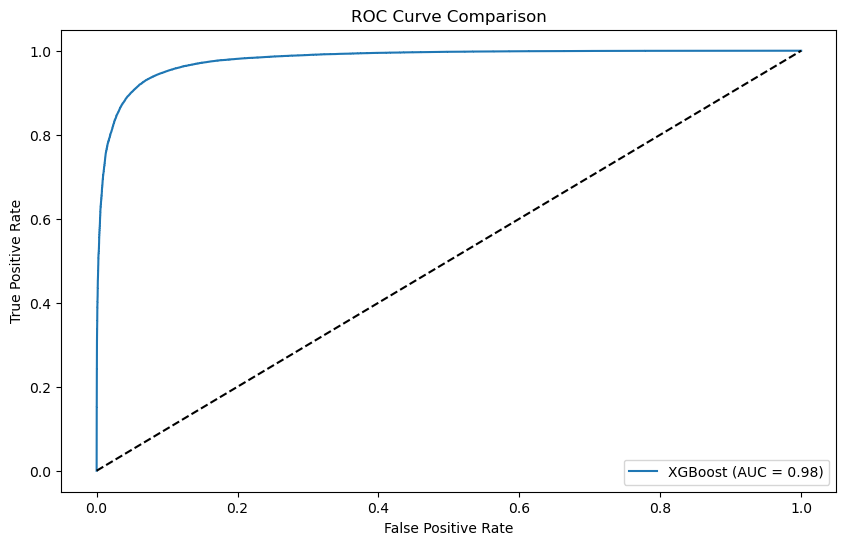

In [9]:
non_numeric_cols = env_cols_non_numeric + env_cols_numeric + machine_cols + datetime_cols + file_cols + image_profile_cols + ['Class']
df_features = df.drop(columns=non_numeric_cols, errors="ignore")

y = df['Class'].map({'Calanoid':0, 'Cyclopoid':1}) # 0 for Calanoid, 1 for Cyclopoid

X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.2, random_state=42)

# Initialize XGBoost classifier
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=2453,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Calanoid', 'Cyclopoid']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nF1 Score:")
print(f1_score(y_test, y_pred))

print("\nRecall :")
print(recall_score(y_test, y_pred))
print("\nPrecision :")
print(precision_score(y_test, y_pred))

print("\nROC curve:")
xgb_probs = model.predict_proba(X_test)[:, 1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
xgb_auc = auc(xgb_fpr, xgb_tpr)

plt.figure(figsize=(10, 6))
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


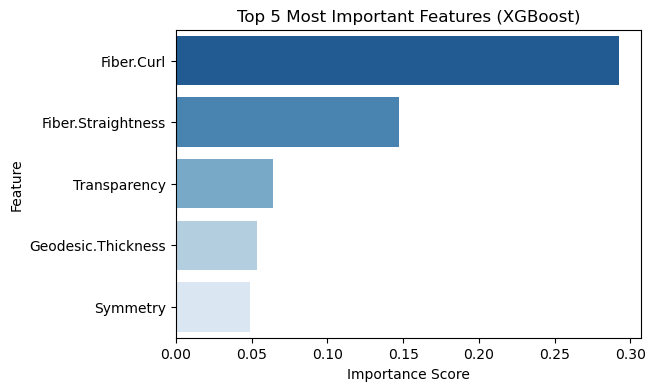

In [10]:
importance = model.feature_importances_
feature_names = df_features.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=True).tail(5)

# Plot sorted feature importance
plt.figure(figsize=(6,4))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="Blues")
plt.xlabel('Importance Score')
plt.title("Top 5 Most Important Features (XGBoost)")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

XGBoost using all the features achieved similar result as random forest, ~93% accuracy / F1 / Recall.

Both methods suggest that Fiber Curl and Fiber Straightness which describe the outline of zooplanktons, are the top 2 factors affecting the classification of Calanoid and Cyclopoid. Actually, based on the definition of these two variables, they are both derived from Geodesic Length and Length.  


Since the performance is really good, let's examine how to eliminate some variables but still achieve a satisfactory result to improve interpretability. 

# With only environmental features

Classification Accuracy: 0.70
              precision    recall  f1-score   support

           0       0.71      0.71      0.71     40529
           1       0.69      0.69      0.69     38324

    accuracy                           0.70     78853
   macro avg       0.70      0.70      0.70     78853
weighted avg       0.70      0.70      0.70     78853


Confusion Matrix:
[[28674 11855]
 [11768 26556]]

F1 Score:
0.6921483025998566

Recall :
0.6929339317399019

Precision :
0.6913644528910989

ROC curve:


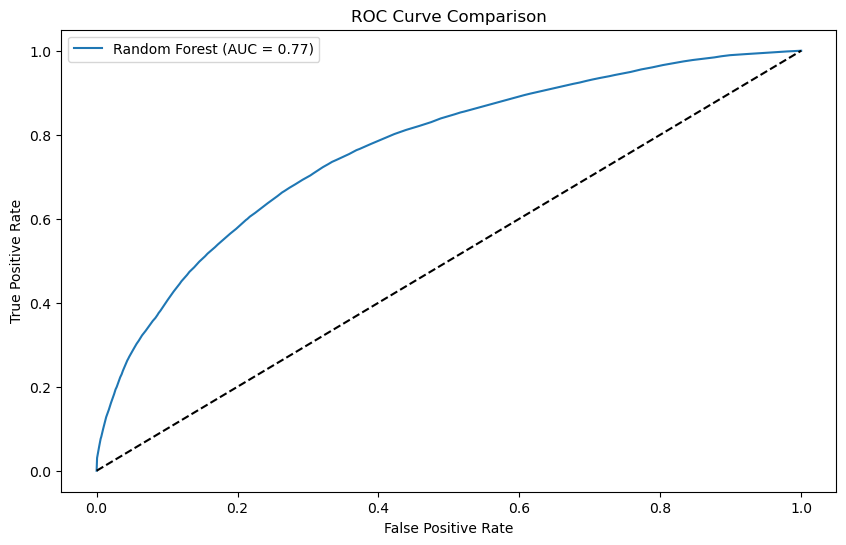

In [11]:
# Random Forest: With only environmental features
features_to_include = env_cols_numeric # select only environmental features
df_features = df[features_to_include]
# Define target variable
y = df['Class'].map({'Calanoid':0, 'Cyclopoid':1}) # 0 for Calanoid, 1 for Cyclopoid

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) 
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nF1 Score:")
print(f1_score(y_test, y_pred))

print("\nRecall :")
print(recall_score(y_test, y_pred))
print("\nPrecision :")
print(precision_score(y_test, y_pred))

print("\nROC curve:")
rf_probs = clf.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = auc(rf_fpr, rf_tpr)

plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

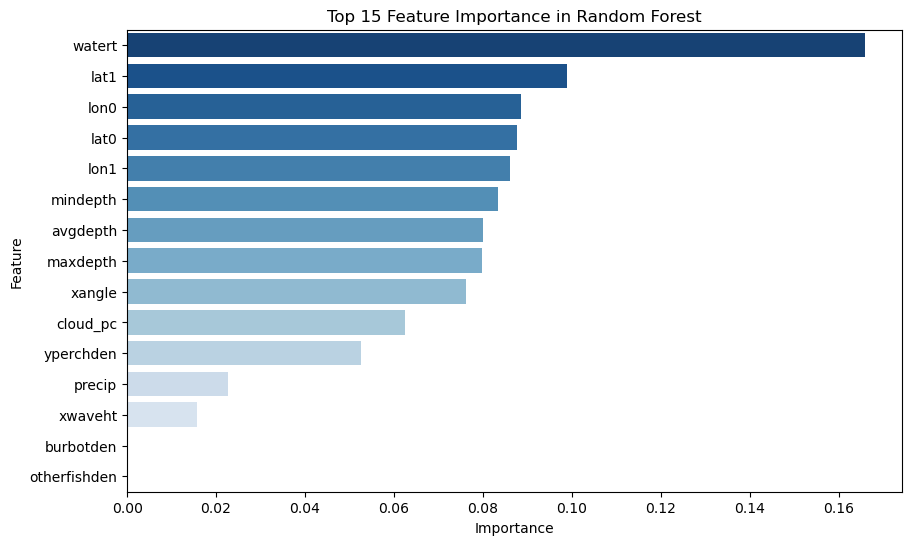

In [12]:
# Get feature importance
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": clf.feature_importances_
})

# Sort and plot top 15 features
feature_importance = feature_importance.sort_values(by="Importance", ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="Blues_r")
plt.title("Top 15 Feature Importance in Random Forest")
plt.show()

/Users/christinaflz/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:15:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Accuracy: 0.70

Classification Report:
              precision    recall  f1-score   support

    Calanoid       0.71      0.71      0.71     40529
   Cyclopoid       0.69      0.69      0.69     38324

    accuracy                           0.70     78853
   macro avg       0.70      0.70      0.70     78853
weighted avg       0.70      0.70      0.70     78853


Confusion Matrix:
[[28674 11855]
 [11768 26556]]

F1 Score:
0.6921483025998566

Recall :
0.6929339317399019

Precision :
0.6913644528910989

ROC curve:


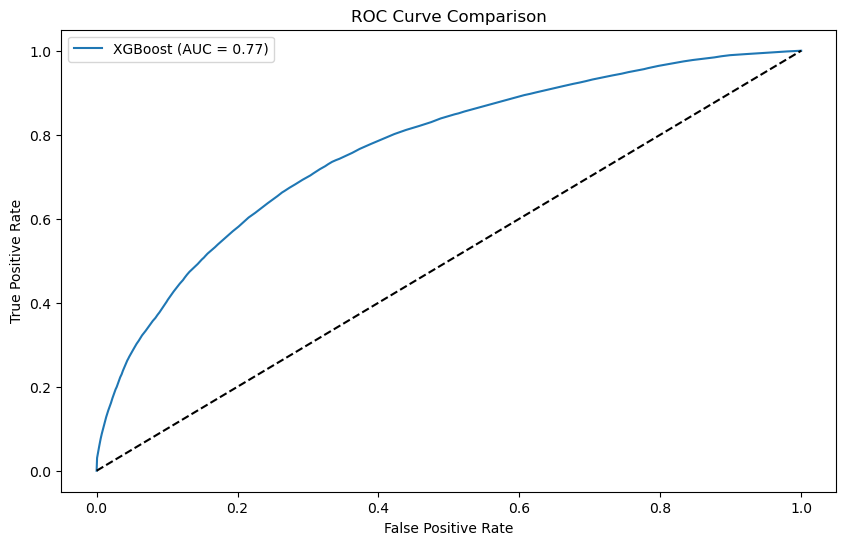

In [13]:
# XGBoost 2: With only environmental features 
features_to_include = env_cols_numeric
df_features = df[features_to_include]
y = df['Class'].map({'Calanoid':0, 'Cyclopoid':1}) # 0 for Calanoid, 1 for Cyclopoid

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.2, random_state=42)

# Initialize XGBoost classifier
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=2453,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Calanoid', 'Cyclopoid']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nF1 Score:")
print(f1_score(y_test, y_pred))

print("\nRecall :")
print(recall_score(y_test, y_pred))
print("\nPrecision :")
print(precision_score(y_test, y_pred))

print("\nROC curve:")
xgb_probs = model.predict_proba(X_test)[:, 1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
xgb_auc = auc(xgb_fpr, xgb_tpr)

plt.figure(figsize=(10, 6))
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


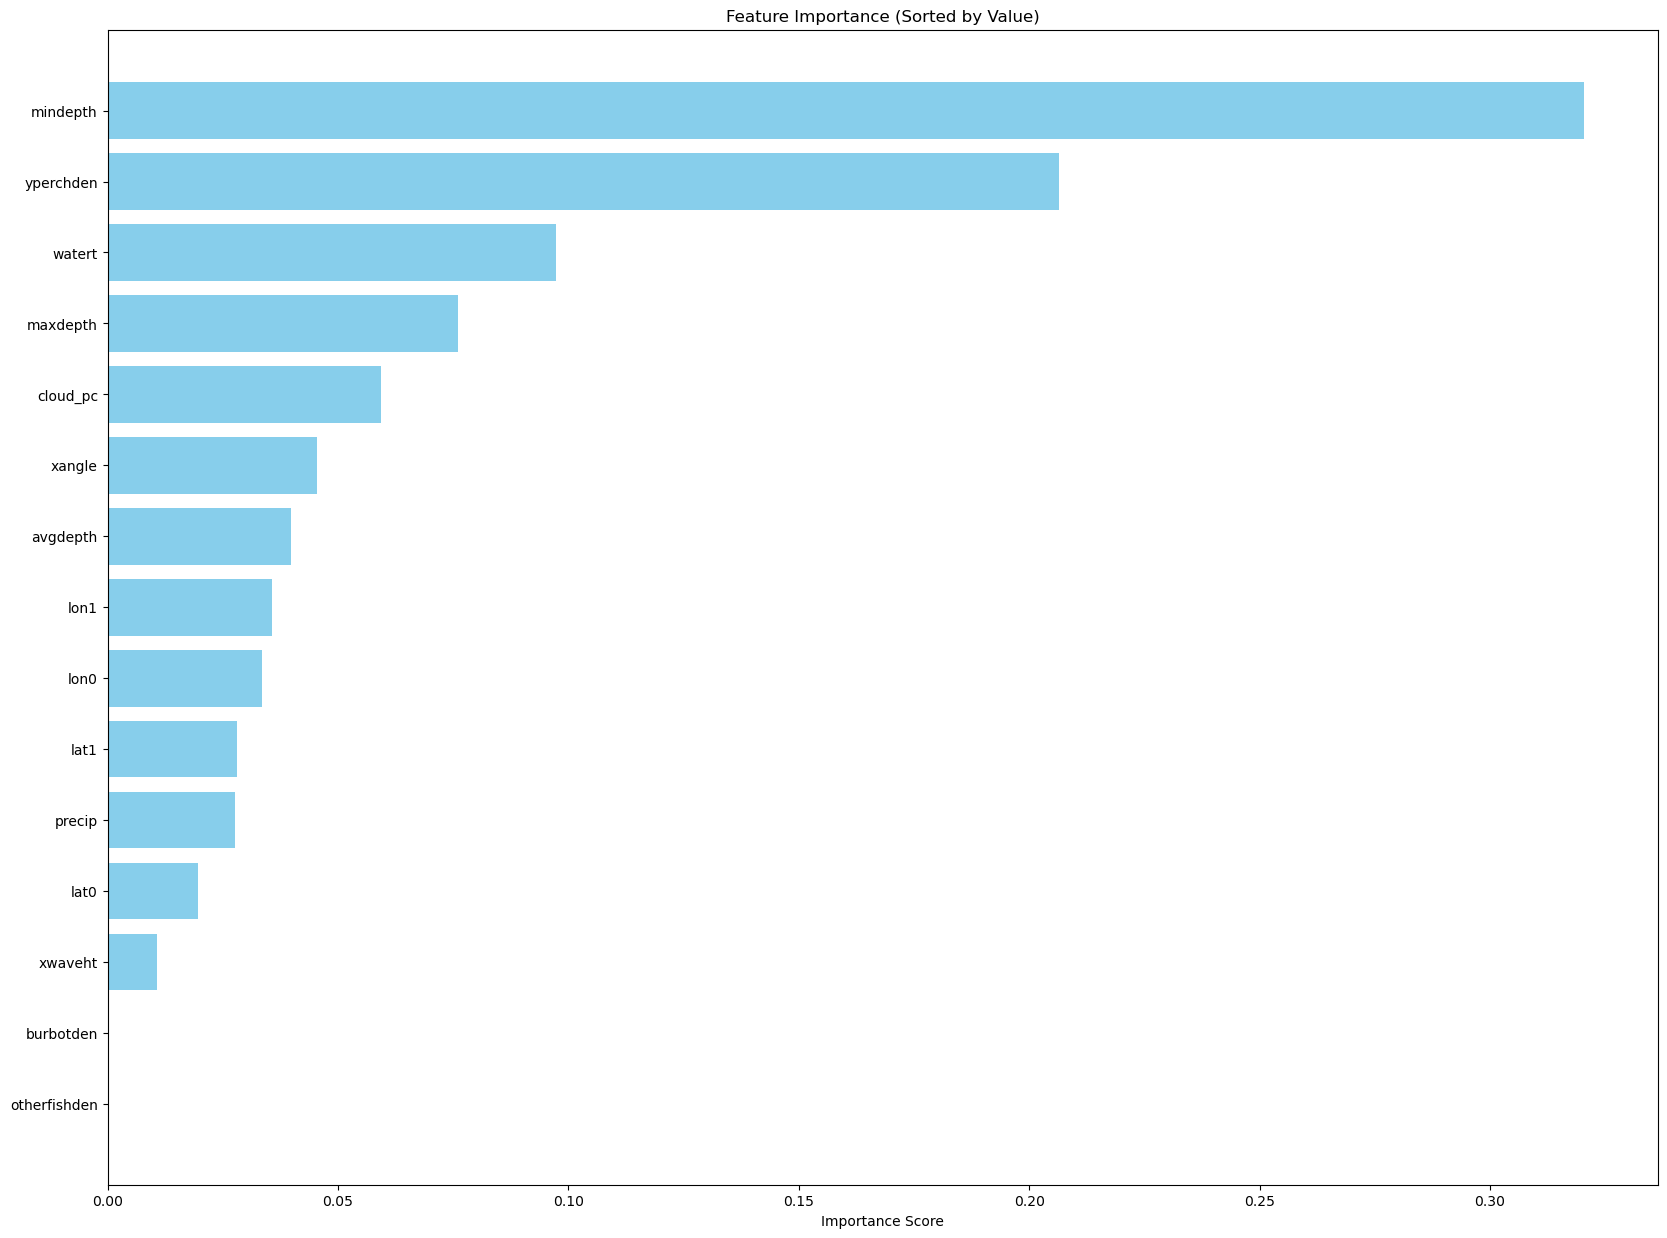

In [14]:
importance = model.feature_importances_
feature_names = df_features.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# Plot sorted feature importance
plt.figure(figsize=(20, 15))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance (Sorted by Value)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

Only using environmental features, the classification result is about 70% accurate. 


# With Environmental features + important image-based features 
Aiming to improve performance and get the top environmental features.

/Users/christinaflz/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:15:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Accuracy: 0.80

Classification Report:
              precision    recall  f1-score   support

    Calanoid       0.82      0.78      0.80     40529
   Cyclopoid       0.78      0.81      0.80     38324

    accuracy                           0.80     78853
   macro avg       0.80      0.80      0.80     78853
weighted avg       0.80      0.80      0.80     78853


Confusion Matrix:
[[31702  8827]
 [ 7169 31155]]

F1 Score:
0.7957244655581949

Recall :
0.8129370629370629

Precision :
0.7792256515431945

ROC curve:


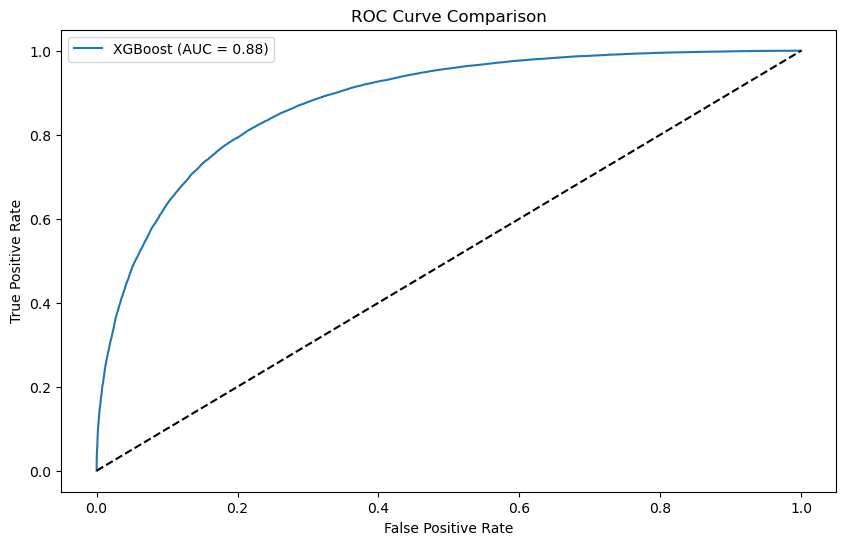

In [15]:
# With only environmental features + most important image-based featuers
features_to_include = env_cols_numeric + ['Fiber.Curl']

df_features = df[features_to_include]
y = df['Class'].map({'Calanoid':0, 'Cyclopoid':1}) 

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.2, random_state=42)

# Initialize XGBoost classifier
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=2453,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Calanoid', 'Cyclopoid']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nF1 Score:")
print(f1_score(y_test, y_pred))

print("\nRecall :")
print(recall_score(y_test, y_pred))
print("\nPrecision :")
print(precision_score(y_test, y_pred))

print("\nROC curve:")
xgb_probs = model.predict_proba(X_test)[:, 1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
xgb_auc = auc(xgb_fpr, xgb_tpr)

plt.figure(figsize=(10, 6))
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


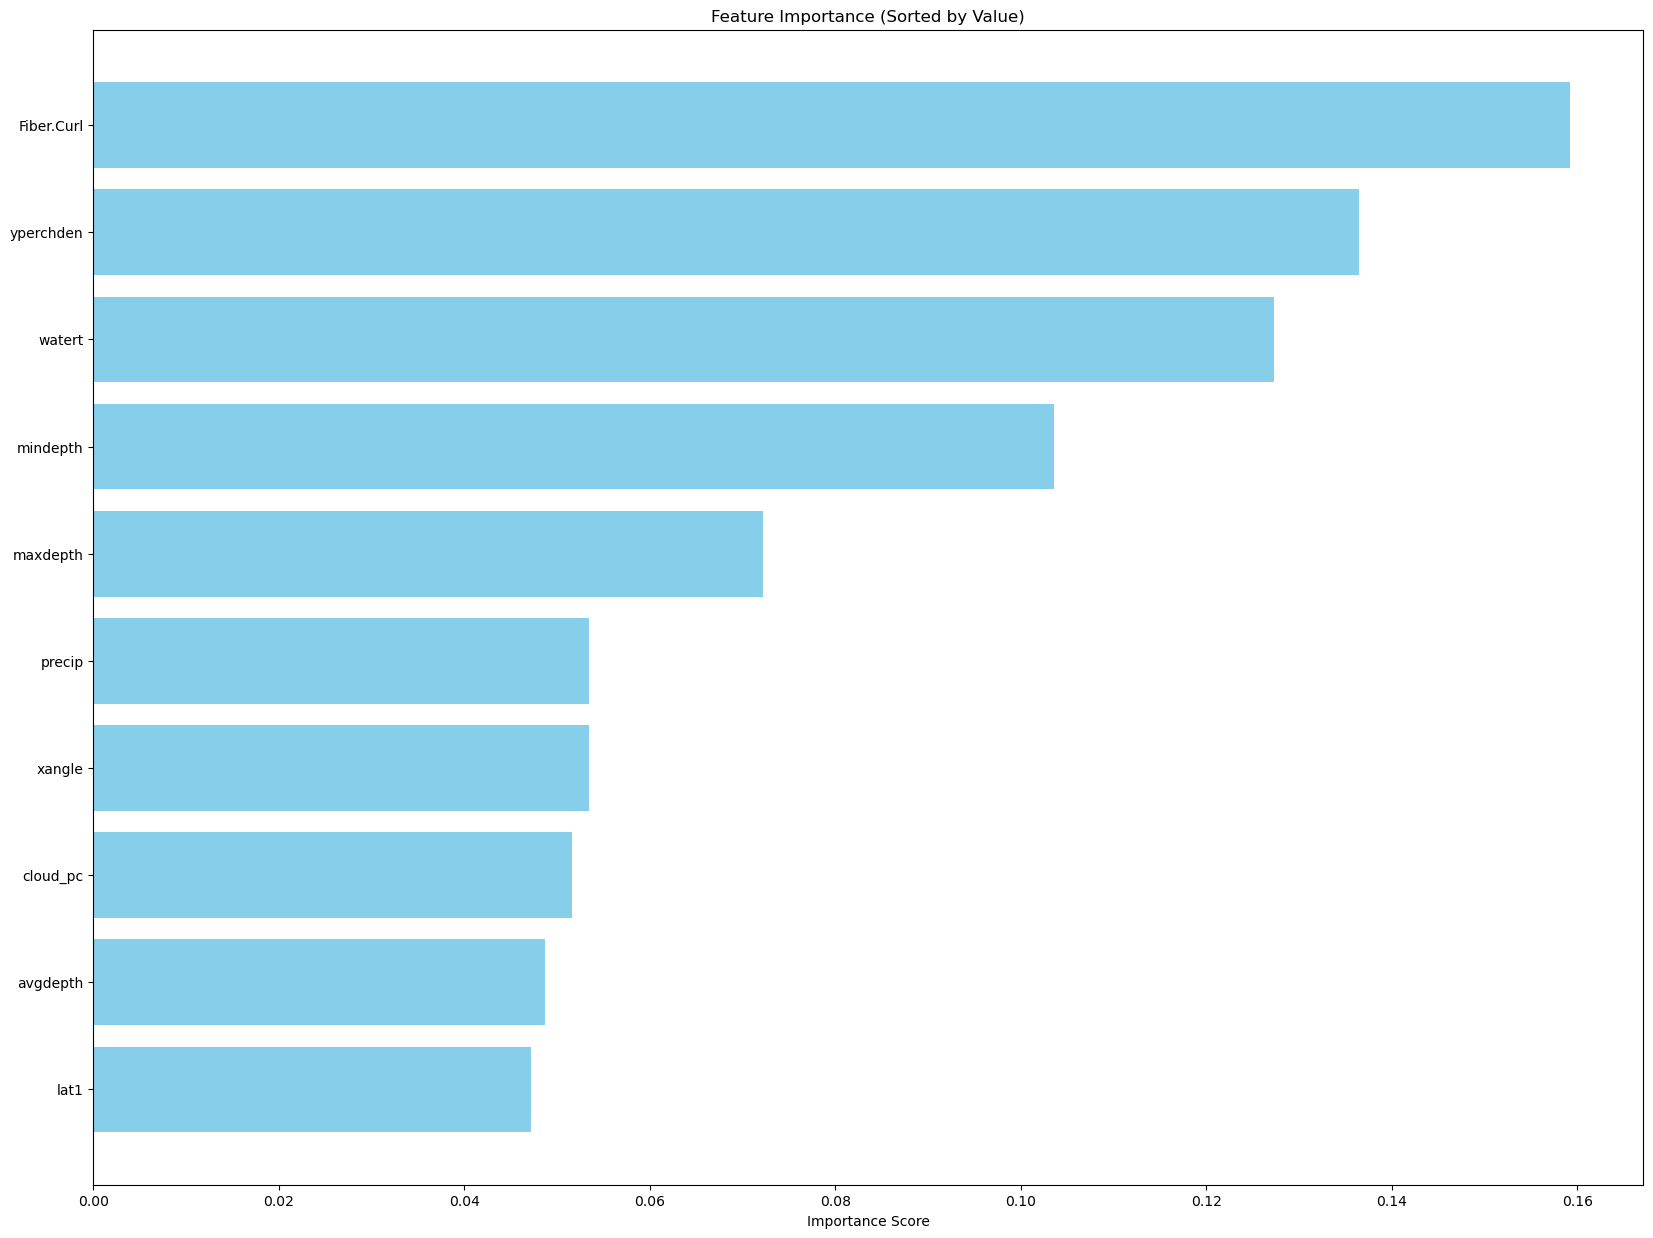

In [16]:
# Feature importance
importance = model.feature_importances_
feature_names = df_features.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False).head(10)

# Plot sorted feature importance
plt.figure(figsize=(20, 15))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance (Sorted by Value)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

`yperchden` and `watert` are the two most important environmental features. The following models use these 2 features as the selected important environmental features.

# With selected important Environmental features + top 2 important image-based features 
Aiming to improve performance

In [17]:
# df[env_cols_non_numeric] = df[env_cols_non_numeric].astype('category')

Classification Accuracy: 0.79
              precision    recall  f1-score   support

           0       0.80      0.79      0.80     40529
           1       0.78      0.79      0.79     38324

    accuracy                           0.79     78853
   macro avg       0.79      0.79      0.79     78853
weighted avg       0.79      0.79      0.79     78853


Confusion Matrix:
[[31997  8532]
 [ 7903 30421]]

F1 Score:
0.7873235244639414

Recall :
0.79378457363532

Precision :
0.7809668061510024

ROC curve:


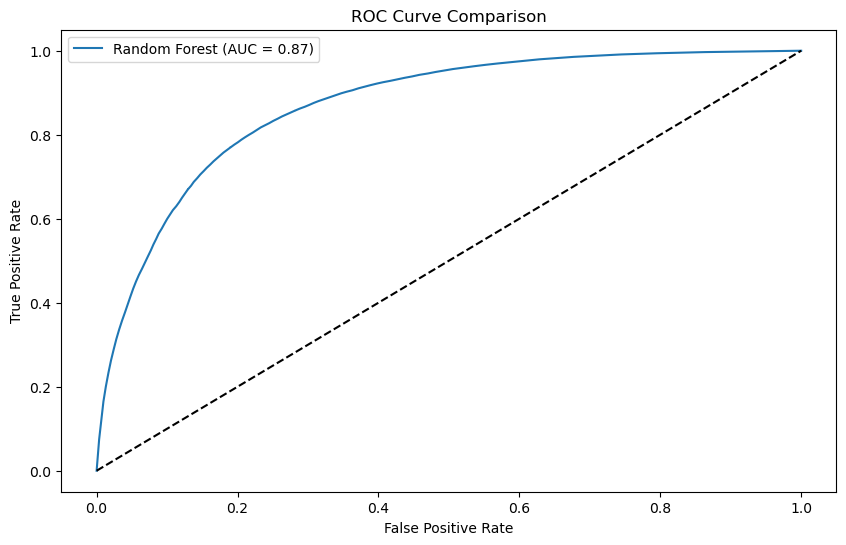

In [18]:
# Random Forest
features_to_include =  ['Fiber.Curl','Aspect.Ratio','yperchden','watert']

df_features = df[features_to_include]
# Define target variable
y = df['Class'].map({'Calanoid':0, 'Cyclopoid':1}) # 0 for Calanoid, 1 for Cyclopoid

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nF1 Score:")
print(f1_score(y_test, y_pred))

print("\nRecall :")
print(recall_score(y_test, y_pred))
print("\nPrecision :")
print(precision_score(y_test, y_pred))

print("\nROC curve:")
rf_probs = clf.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = auc(rf_fpr, rf_tpr)

plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

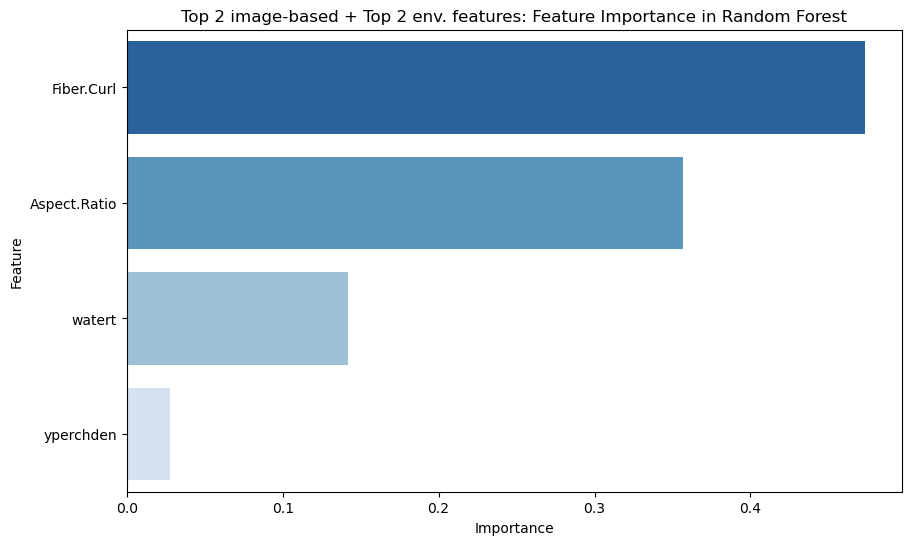

In [19]:
# Get feature importance
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": clf.feature_importances_
})

# Sort and plot top 15 features
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="Blues_r")
plt.title("Top 2 image-based + Top 2 env. features: Feature Importance in Random Forest")
plt.show()

/Users/christinaflz/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:17:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Accuracy: 0.81

Classification Report:
              precision    recall  f1-score   support

    Calanoid       0.83      0.79      0.81     40529
   Cyclopoid       0.79      0.83      0.81     38324

    accuracy                           0.81     78853
   macro avg       0.81      0.81      0.81     78853
weighted avg       0.81      0.81      0.81     78853


Confusion Matrix:
[[32057  8472]
 [ 6476 31848]]

F1 Score:
0.809928284420935

Recall :
0.8310197265421146

Precision :
0.7898809523809524

ROC curve:


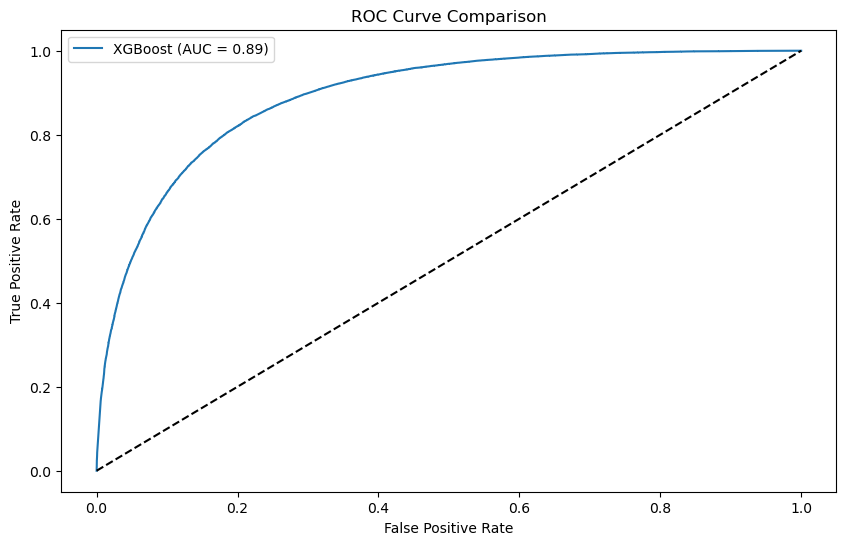

In [28]:
# XGBoost
features_to_include =  ['Fiber.Curl','Aspect.Ratio','yperchden','watert']

df_features = df[features_to_include]
y = df['Class'].map({'Calanoid':0, 'Cyclopoid':1}) # 0 for Calanoid, 1 for Cyclopoid

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.2, random_state=42)

# Initialize XGBoost classifier
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=2453,
    use_label_encoder=False,
    eval_metric='logloss',
    enable_categorical=True
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Calanoid', 'Cyclopoid']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nF1 Score:")
print(f1_score(y_test, y_pred))

print("\nRecall :")
print(recall_score(y_test, y_pred))
print("\nPrecision :")
print(precision_score(y_test, y_pred))

print("\nROC curve:")
xgb_probs = model.predict_proba(X_test)[:, 1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
xgb_auc = auc(xgb_fpr, xgb_tpr)

plt.figure(figsize=(10, 6))
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


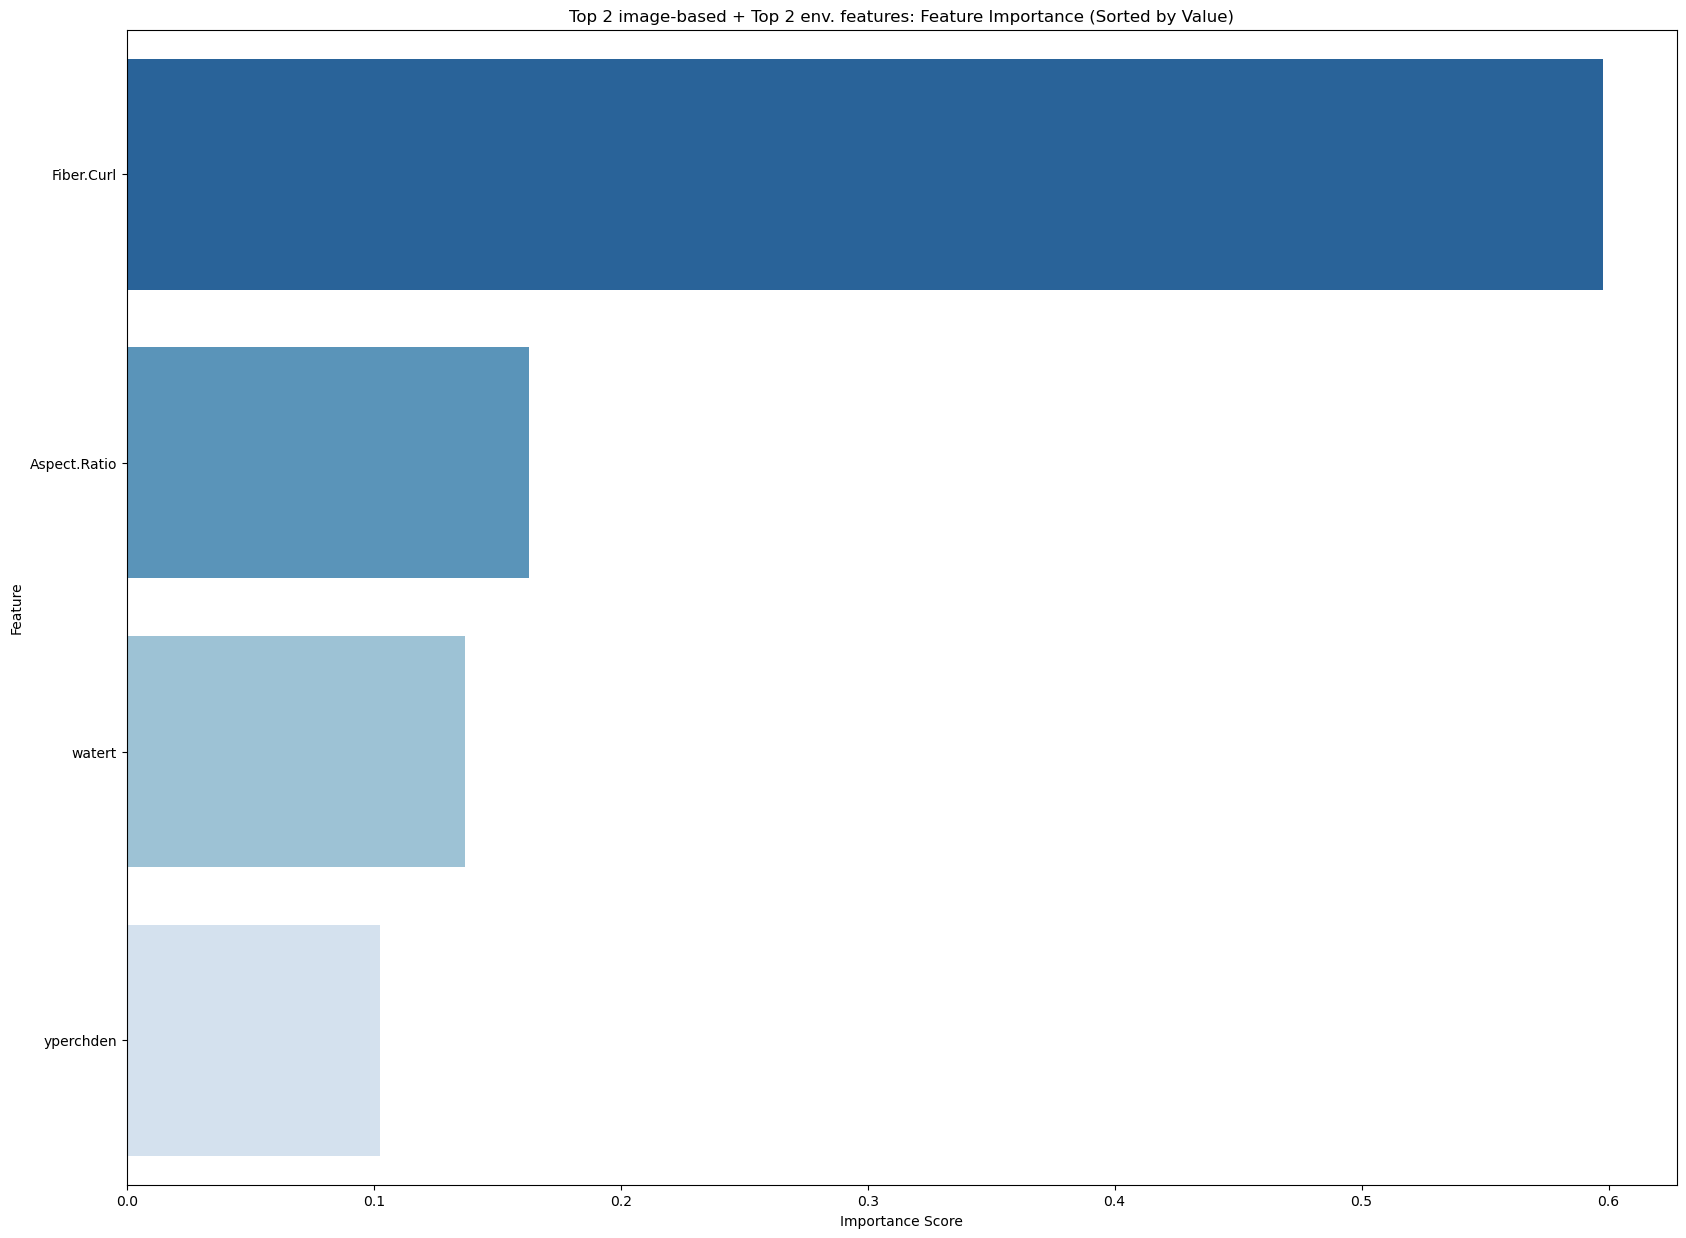

In [ ]:
importance = model.feature_importances_
feature_names = df_features.columns

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=True)

# Plot sorted feature importance
plt.figure(figsize=(20, 15))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="Blues")

plt.xlabel('Importance Score')
plt.title('Top 2 image-based + Top 2 env. features: Feature Importance (Sorted by Value)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

# Final model
Using only 8 features (6 image-based + 2 environmental features)

Classification Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     40529
           1       0.90      0.90      0.90     38324

    accuracy                           0.91     78853
   macro avg       0.91      0.91      0.91     78853
weighted avg       0.91      0.91      0.91     78853


Confusion Matrix:
[[36758  3771]
 [ 3693 34631]]

F1 Score:
0.9027187654771524

Recall :
0.9036374073687506

Precision :
0.9018019894797146

ROC curve:


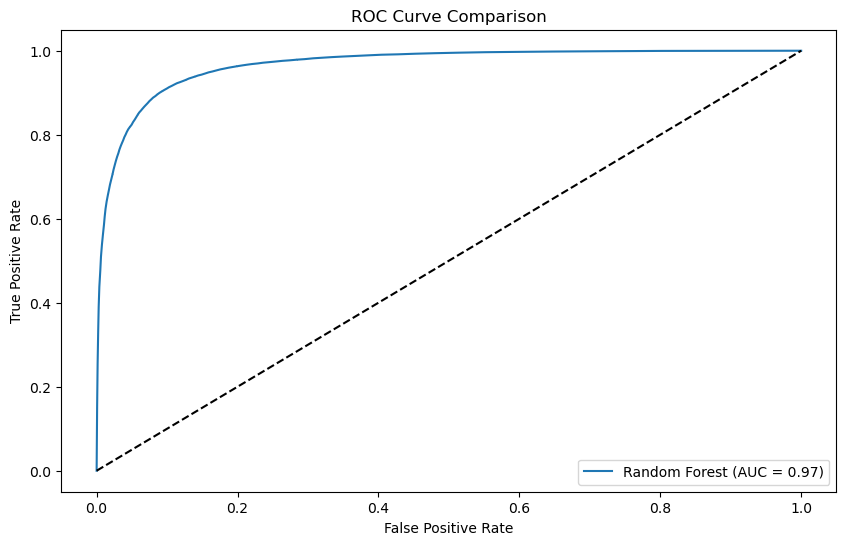

In [31]:
features_to_include =  ['Geodesic.Thickness','Fiber.Straightness','Transparency','Aspect.Ratio','Convexity','Symmetry','yperchden','watert'] 

df_features = df[features_to_include]

# Define target variable
y = df['Class'].map({'Calanoid':0, 'Cyclopoid':1}) # 0 for Calanoid, 1 for Cyclopoid

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)  
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nF1 Score:")
print(f1_score(y_test, y_pred))

print("\nRecall :")
print(recall_score(y_test, y_pred))
print("\nPrecision :")
print(precision_score(y_test, y_pred))

print("\nROC curve:")
rf_probs = clf.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = auc(rf_fpr, rf_tpr)

plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

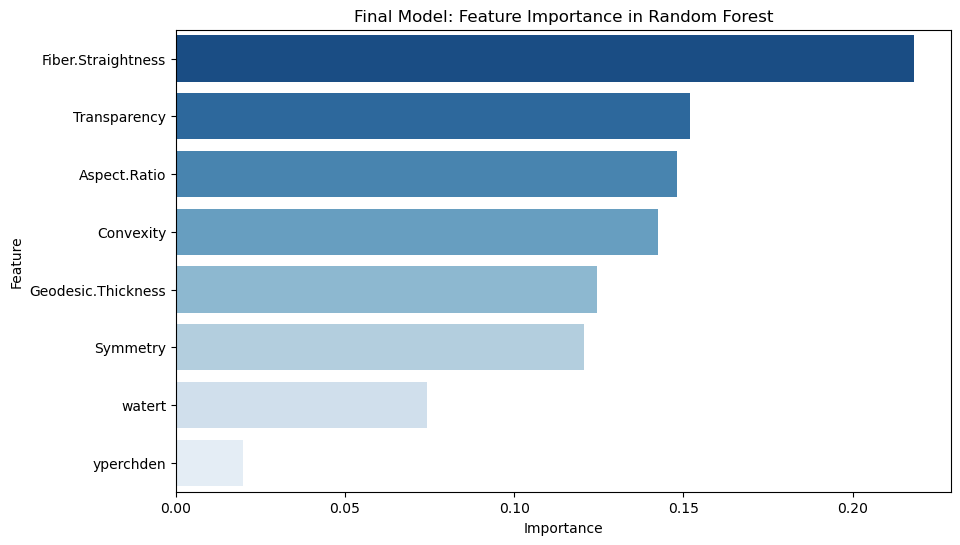

In [32]:
# Get feature importance
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": clf.feature_importances_
})

# Sort and plot top 15 features
feature_importance = feature_importance.sort_values(by="Importance", ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance, palette="Blues_r")
plt.title("Final Model: Feature Importance in Random Forest")
plt.show()


Accuracy: 0.88

Classification Report:
              precision    recall  f1-score   support

    Calanoid       0.89      0.86      0.88    201868
   Cyclopoid       0.86      0.89      0.88    192395

    accuracy                           0.88    394263
   macro avg       0.88      0.88      0.88    394263
weighted avg       0.88      0.88      0.88    394263


Confusion Matrix:
[[174413  27455]
 [ 21257 171138]]

F1 Score: 0.8754130561551762
Recall: 0.8895137607526183
Precision: 0.861752428333325


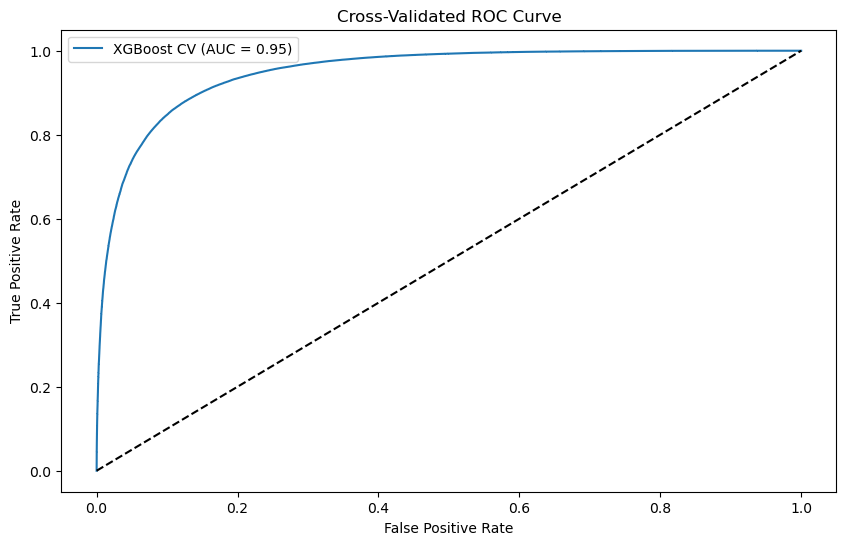

In [24]:
# You may select any of the following set of features to test performance
# features_to_include =  ['Fiber.Straightness','Transparency','Convexity','Intensity','yperchden','watert'] # 0.87
# features_to_include =  ['Fiber.Straightness','Transparency','Aspect.Ratio','yperchden','watert'] # 0.87
# features_to_include =  ['Fiber.Straightness','Transparency','yperchden','watert'] # 0.84
features_to_include =  ['Fiber.Straightness','Transparency','Aspect.Ratio','Convexity','yperchden','watert'] # 0.88, 0.85 without env factors
# features_to_include =  ['Fiber.Straightness','Transparency','Aspect.Ratio','Convexity','Symmetry','yperchden','watert'] # 0.89, 0.87 without env factors
# features_to_include =  ['Geodesic.Thickness','Fiber.Straightness','Transparency','Aspect.Ratio','Convexity','Symmetry','yperchden','watert'] # 0.90. 0.88 withouth env factors

# Prepare features and target
df_features = df[features_to_include]
y = df['Class'].map({'Calanoid': 0, 'Cyclopoid': 1}) 

# Initialize model
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=2453,
    eval_metric='logloss',
    enable_categorical=True
)

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get cross-validated predictions
y_pred = cross_val_predict(model, df_features, y, cv=cv, method='predict')
y_probs = cross_val_predict(model, df_features, y, cv=cv, method='predict_proba')[:, 1]

# Evaluate
print(f"\nAccuracy: {accuracy_score(y, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=['Calanoid', 'Cyclopoid']))
print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))
print("\nF1 Score:", f1_score(y, y_pred))
print("Recall:", recall_score(y, y_pred))
print("Precision:", precision_score(y, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'XGBoost CV (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Cross-Validated ROC Curve')
plt.legend()
plt.show()


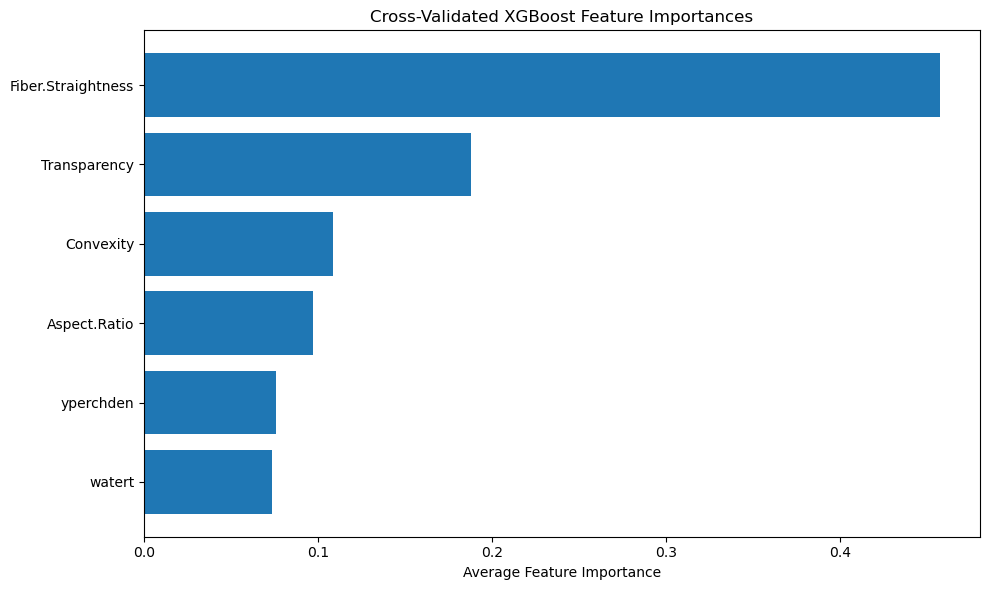

In [25]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
importances_list = []

for train_idx, val_idx in cv.split(df_features, y):
    X_train, X_val = df_features.iloc[train_idx], df_features.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=2453,
        eval_metric='logloss',
        enable_categorical=True
    )
    model.fit(X_train, y_train)
    importances_list.append(model.feature_importances_)

# Average the importances
avg_importances = np.mean(importances_list, axis=0)

# Plot
sorted_idx = np.argsort(avg_importances)
plt.figure(figsize=(10, 6))
plt.barh(range(len(avg_importances)), avg_importances[sorted_idx], align='center')
plt.yticks(range(len(avg_importances)), [df_features.columns[i] for i in sorted_idx])
plt.xlabel("Average Feature Importance")
plt.title("Cross-Validated XGBoost Feature Importances")
plt.tight_layout()
plt.show()
